# Data Analisis Assignment - Group 1
## Introduction
The goal of this project is to analyze hourly electricity generation in Spain, broken down by autonomous community and generation technology. We aim to extract and explore key insights from the data, identify regional and technological trends, and optionally examine correlations between different data sources.
## Task 1: Data Extraction and Saving
The data extraction process is carried out through the Red Eléctrica de España (REE) API. An interactive user interface allows users to input the desired autonomous community and time period. Based on these inputs, the program retrieves the corresponding hourly electricity generation data and exports it to an Excel file named in the format: "Generation_[AutonomousCommunity][StartDate][EndDate]".

__Inputs:__
- Region Code
- Start Date
- End Date

__Output:__
- Excel file with columns: datetime, value by technology, percentage value by technology

In [1]:
import requests
import json
import pandas as pd
from datetime import datetime as dt

# Geo_id per region according to the REE API:
# https://www.ree.es/es/datos/apidatos
# ───────────────────────────────────────────────────────────────────────────
# 1. Dictionary REGIONS  →  readable key  →  API id
# ───────────────────────────────────────────────────────────────────────────
REGIONES = {
    "Andalucía": 4,
    "Aragón": 5,
    "Cantabria": 6,
    "Asturias": 11,
    "Castilla y León": 8,
    "Castilla-La Mancha": 7,
    "Cataluña": 9,
    "Comunidad Valenciana": 15,
    "Extremadura": 16,
    "Galicia": 17,
    "Madrid": 8752,
    "Murcia": 21,
    "Navarra": 14,
    "País Vasco": 10,
    "La Rioja": 20,
    "Islas Baleares": 8743,
    "Islas Canarias": 8742,
    "Ceuta": 8744,
    "Melilla": 8745,
    "Península": 8741,
}

# ───────────────────────────────────────────────────────────────────────────
# 2. Interactive selection (region + dates)
# ───────────────────────────────────────────────────────────────────────────
print("╔══════════════════════════════════════════╗")
print("║   Available Regions (geo_limit=ccaa)     ║")
print("╚══════════════════════════════════════════╝")

for n, reg in enumerate(REGIONES, 1):
    print(f"{n:>2}. {reg}")

# --- Select region ---
while True:
    try:
        idx = int(input("\nNumber of desired region: "))
        region_name = list(REGIONES)[idx - 1]
        geo_id = REGIONES[region_name]
        break
    except (ValueError, IndexError):
        print("⛔ Invalid choice, try again…")

# --- Date input ---
def ask_date(prompt):
    while True:
        try:
            txt = input(prompt)
            return dt.strptime(txt.strip(), "%Y-%m-%d %H:%M")
        except ValueError:
            print("⛔ Invalid format. Example: 2019-01-01 00:00")

start = ask_date("\nStart date (YYYY-MM-DD HH:MM): ")
end   = ask_date("End date   (YYYY-MM-DD HH:MM): ")
if end <= start:
    raise ValueError("End date must be after the start date.")

print(f"\n▶ Region: {region_name}  (geo_id = {geo_id})")
print(f"▶ Period: {start}  →  {end}\n")

# ───────────────────────────────────────────────────────────────────────────
# 3. API call function (daily granularity)
# ───────────────────────────────────────────────────────────────────────────
def get_gen(geo_id, start_date, end_date):
    url = "https://apidatos.ree.es/es/datos/generacion/estructura-generacion"

    headers = {
        "Accept": "application/json",
    }

    params = {
        "start_date": start_date,
        "end_date": end_date,
        "time_trunc": "day",
        "geo_limit":  "ccaa",
        "geo_id": geo_id
    }

    response = requests.get(url, headers=headers, params=params)

    if response.status_code != 200:
        print(f"⛔ Error {response.status_code}")
        print(response.text)
        return pd.DataFrame()  # <- Return empty DataFrame on failure

    data = response.json()

    # Extract generation data
    rows = []
    for technology in data["included"]:
        name = technology["attributes"]["title"]
        for v in technology["attributes"]["values"]:
            rows.append({
                "datetime": v["datetime"],
                "value": v["value"],
                "percentage": v["percentage"],
                "technology": name
            })

    return pd.DataFrame(rows)

# Call API
df = get_gen(geo_id, start, end)


if df.empty:
    print("❗ No data found. Please verify your input.")
else:
    print(df.head())
    # Format dates to string
    start_str = start.strftime("%Y%m%d")
    end_str   = end.strftime("%Y%m%d")

    # Export to Excel
    archivo_excel = f"generacion_{region_name.replace(' ', '_').lower()}_{start_str}_{end_str}.xlsx"
    df.to_excel(archivo_excel, index=False)
    print(f"✅ Data saved to: {archivo_excel}")

╔══════════════════════════════════════════╗
║   Available Regions (geo_limit=ccaa)     ║
╚══════════════════════════════════════════╝
 1. Andalucía
 2. Aragón
 3. Cantabria
 4. Asturias
 5. Castilla y León
 6. Castilla-La Mancha
 7. Cataluña
 8. Comunidad Valenciana
 9. Extremadura
10. Galicia
11. Madrid
12. Murcia
13. Navarra
14. País Vasco
15. La Rioja
16. Islas Baleares
17. Islas Canarias
18. Ceuta
19. Melilla
20. Península

Number of desired region: 2020-01-01 00:00
⛔ Invalid choice, try again…

Number of desired region: 20

Start date (YYYY-MM-DD HH:MM): 2020-01-01 00:00
End date   (YYYY-MM-DD HH:MM): 2020-01-31 00:00

▶ Region: Península  (geo_id = 8741)
▶ Period: 2020-01-01 00:00:00  →  2020-01-31 00:00:00

                        datetime       value  percentage  technology
0  2020-01-01T00:00:00.000+01:00  151481.978    0.006559  Hidráulica
1  2020-01-02T00:00:00.000+01:00  159171.675    0.229885  Hidráulica
2  2020-01-03T00:00:00.000+01:00  151996.921    0.226005  Hidráulica

## Task 2: Data Preprocessing and Cleaning

__Inputs:__
- dataframe "df" with columns: datetime, value, percentage, technology

__Output:__
- dataframe 'daily_pivot': Containing the daily production values and percentages of each techonlogy
- dataframe 'monthly_pivot': Containing the monthly production values and percentages of each techonlogy

In [26]:
# Display the top 5 rows of the Dataframe
df.head()

,datetime,value,percentage,technology,day,month,date
0,2020-01-01 00:00:00+01:00,1.514820e+05,0.006559,Hidráulica,1,2020-01,2020-01-01
351,2020-01-01 00:00:00+01:00,8.373805e+03,0.000363,Otras renovables,1,2020-01,2020-01-01
479,2020-01-01 00:00:00+01:00,2.309634e+07,1.000000,Generación total,1,2020-01,2020-01-01
160,2020-01-01 00:00:00+01:00,3.941224e+03,0.000171,Turbina de vapor,1,2020-01,2020-01-01
31,2020-01-01 00:00:00+01:00,3.729344e+06,0.161469,Hidráulica,1,2020-01,2020-01-01


In [3]:
# Display information about the data including the index dtype and columns, non-null values and memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    510 non-null    object 
 1   value       510 non-null    float64
 2   percentage  510 non-null    float64
 3   technology  510 non-null    object 
dtypes: float64(2), object(2)
memory usage: 16.1+ KB


In [4]:
# Display descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.
df.describe()

,value,percentage
count,5.100000e+02,5.100000e+02
mean,1.738151e+05,1.215686e-01
std,1.105520e+06,2.392436e-01
min,1.220000e-01,2.601559e-07
25%,3.927179e+03,4.458084e-03
50%,1.178186e+04,1.577859e-02
75%,1.105605e+05,1.349513e-01
max,2.309634e+07,1.000000e+00


In [5]:
# Check data for missing values
missing_values = df.isnull().sum()

# Filter columns with missing values
missing_cols = missing_values[missing_values > 0]

# Print results
if missing_cols.empty:
    print("No null values found.")
else:
    print("Missing values found in the following columns:")
    print(missing_cols)
    print("\nPossible treatments:")
    print("- Drop rows with missing values: df.dropna(inplace=True)")
    print("- Fill missing values (example: fill with mean): df.fillna(df.mean(), inplace=True)")

No null values found.


In [6]:
# Convert datetime column
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")

In [7]:
# Sort by datetime just in case
df = df.sort_values('datetime')

### Dataframe restructure:
The dataframe 'df' now is structured like in the columns:
- datetime
- value
- percentage
- technology

Note that all the first dates of a month contain two values: one for the actual value and percentage of the technology of that date and one for the cummulated value and percentage of the month.

To fix this the dataframe is restructured into two resulting ones. One with the monthly statistics and one with the daily statistics.

In [8]:
# Restructure to get the dataframe for the daily data.
# Output structure: datetime	value_[technology]	percentage_[technology]

# Drop the cumulative rows — keep only the first daily entry
daily_df = df.copy()
daily_df['day'] = daily_df['datetime'].dt.date

# For each day and technology, keep only the minimum value (assuming the cumulative has higher value)
daily_df = daily_df.sort_values(['datetime', 'technology', 'value']).drop_duplicates(['day', 'technology'], keep='first')

# Pivot to wide format
daily_pivot = daily_df.pivot(index='datetime', columns='technology', values=['value', 'percentage'])

# Flatten MultiIndex columns
daily_pivot.columns = [f"{col[0]}_{col[1]}" for col in daily_pivot.columns]
daily_pivot = daily_pivot.reset_index()

# Check for the results
daily_pivot.head()

,datetime,value_Carbón,value_Ciclo combinado,value_Cogeneración,value_Eólica,value_Generación total,value_Hidroeólica,value_Hidráulica,value_Motores diésel,value_Nuclear,...,percentage_Hidráulica,percentage_Motores diésel,percentage_Nuclear,percentage_Otras renovables,percentage_Residuos no renovables,percentage_Residuos renovables,percentage_Solar fotovoltaica,percentage_Solar térmica,percentage_Turbina de gas,percentage_Turbina de vapor
0,2020-01-01 00:00:00+01:00,8634.057,119850.631,58759.866,23525.794,2.309634e+07,25.172,151481.978,6225.581,170552.654,...,0.006559,0.000270,0.007384,0.000363,0.000182,0.000106,0.000981,0.000230,0.000037,0.000171
1,2020-01-02 00:00:00+01:00,13528.944,146487.644,73625.417,77426.389,6.923962e+05,21.048,159171.675,7044.773,170547.966,...,0.229885,0.010174,0.246316,0.012143,0.005550,0.003055,0.027411,0.005665,0.002889,0.007618
2,2020-01-03 00:00:00+01:00,15005.648,121440.647,81302.220,84099.112,6.725393e+05,21.957,151996.921,7882.421,170574.170,...,0.226005,0.011720,0.253627,0.013371,0.006695,0.003146,0.025810,0.001073,0.002176,0.007527
3,2020-01-04 00:00:00+01:00,14957.816,85075.701,77322.202,125320.489,6.672864e+05,14.807,139873.002,7270.960,170642.767,...,0.209615,0.010896,0.255726,0.014311,0.007429,0.003329,0.032608,0.004673,0.001519,0.006278
4,2020-01-05 00:00:00+01:00,19109.375,88257.111,75671.517,61809.342,6.029830e+05,20.221,126801.179,6657.907,170645.456,...,0.210290,0.011042,0.283002,0.016634,0.008054,0.003727,0.044074,0.009204,0.001316,0.006565


In [9]:
# Restructure to get the dataframe for the monthly data.
# Output structure: datetime	value_[technology]	percentage_[technology]

# Get cumulative values: assume they are the maximum for each technology on the first day of the month
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.to_period('M')

# Filter to first day of month
monthly_df = df[df['day'] == 1]

# For each month and technology, keep the **max** value (cumulative)
monthly_cum = monthly_df.sort_values(['value'], ascending=False).drop_duplicates(['month', 'technology'], keep='first')

# Pivot to wide format
monthly_pivot = monthly_cum.pivot(index='month', columns='technology', values=['value', 'percentage'])

# Flatten MultiIndex columns
monthly_pivot.columns = [f"{col[0]}_{col[1]}" for col in monthly_pivot.columns]
monthly_pivot = monthly_pivot.reset_index()

# Check for the results
monthly_pivot.head()

<ipython-input-9-ea5c38e5e3f3>:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['datetime'].dt.to_period('M')


,month,value_Carbón,value_Ciclo combinado,value_Cogeneración,value_Eólica,value_Generación total,value_Hidroeólica,value_Hidráulica,value_Motores diésel,value_Nuclear,...,percentage_Hidráulica,percentage_Motores diésel,percentage_Nuclear,percentage_Otras renovables,percentage_Residuos no renovables,percentage_Residuos renovables,percentage_Solar fotovoltaica,percentage_Solar térmica,percentage_Turbina de gas,percentage_Turbina de vapor
0,2020-01,865887.004,3856118.343,2440531.494,4626864.398,2.309634e+07,824.55,3729343.838,236418.961,5289146.024,...,0.161469,0.010236,0.229004,0.014518,0.007245,0.002795,0.027075,0.003722,0.001686,0.006361


<ipython-input-10-a8a0335a3cd0>:13: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores = np.abs(stats.zscore(data, nan_policy='omit'))


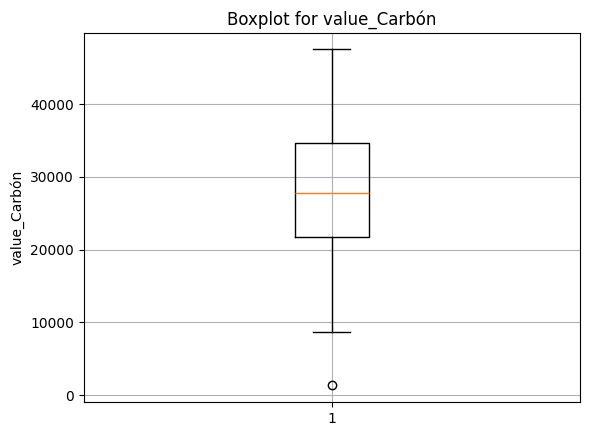

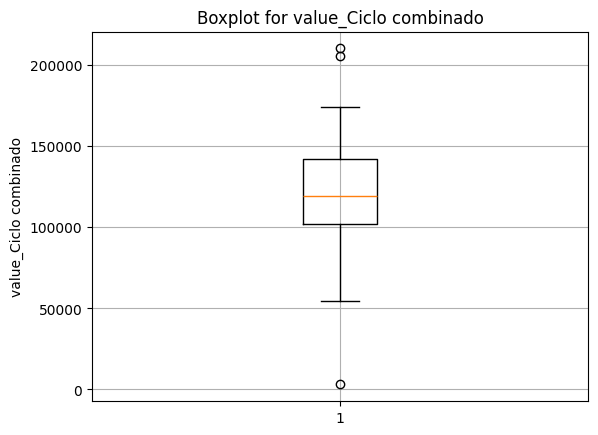

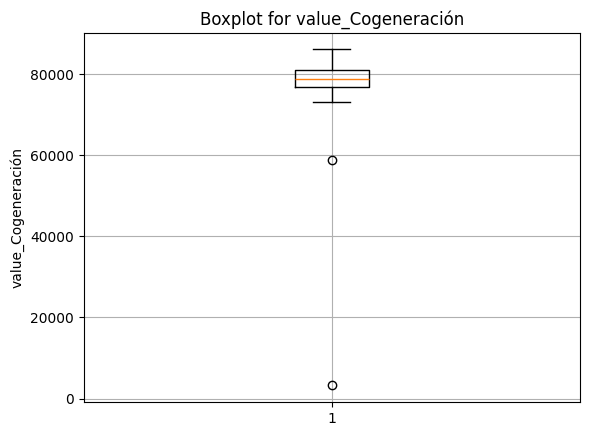

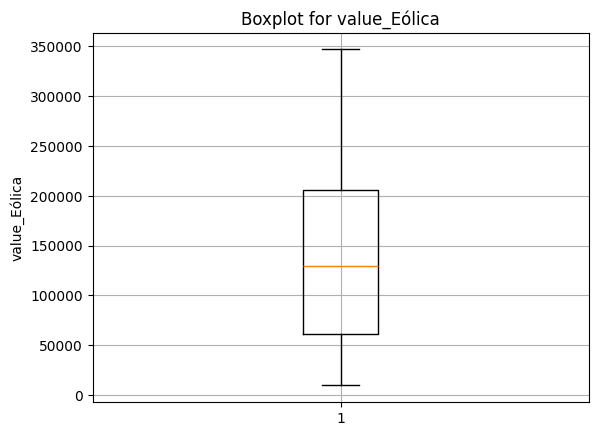

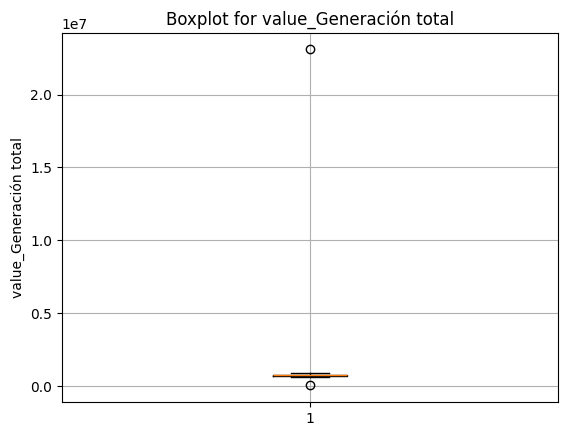

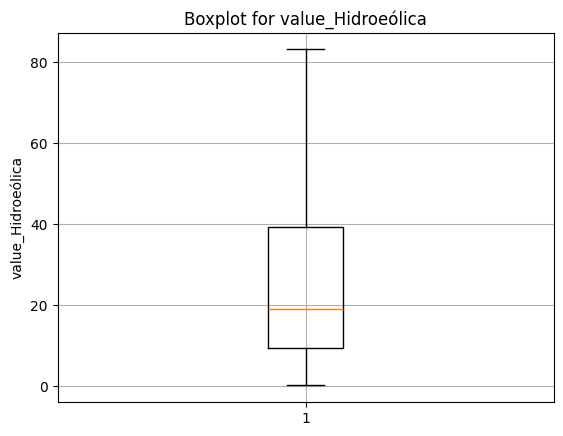

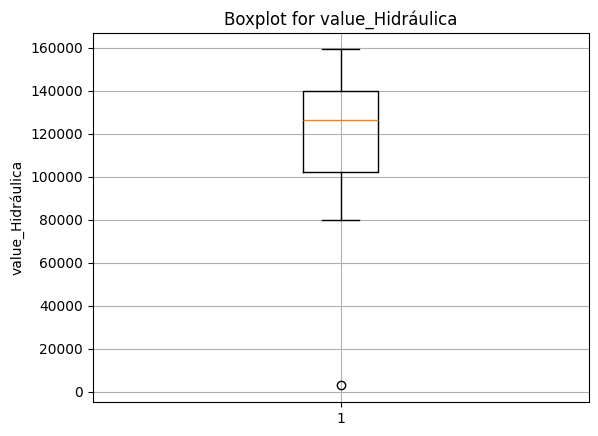

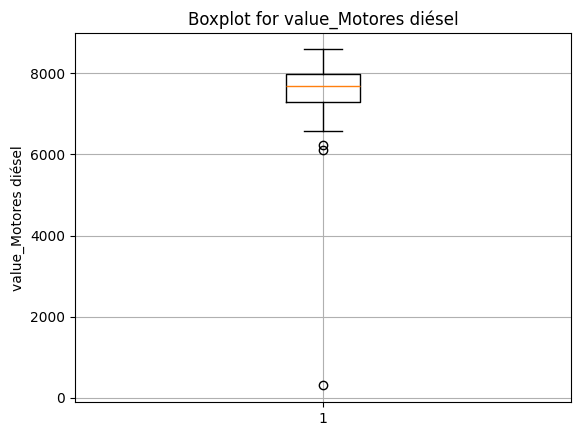

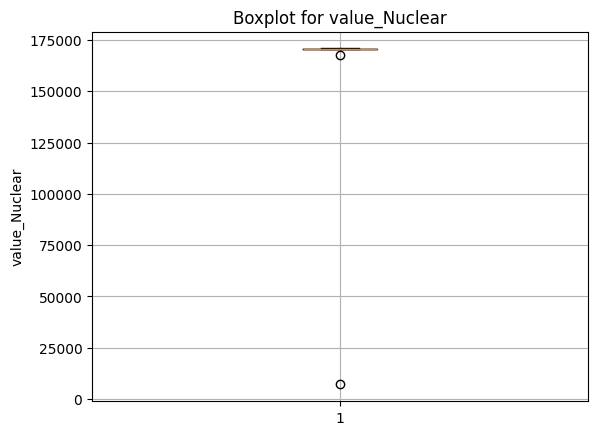

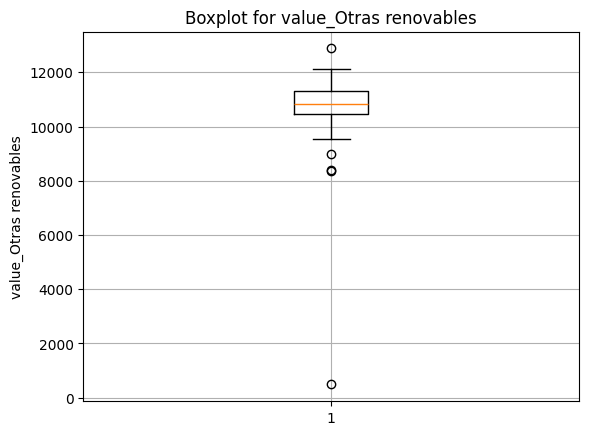

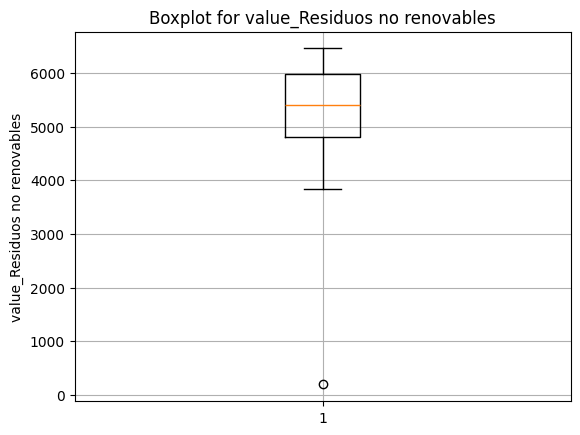

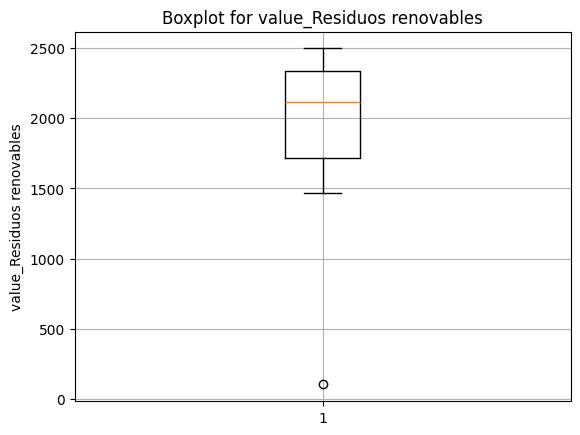

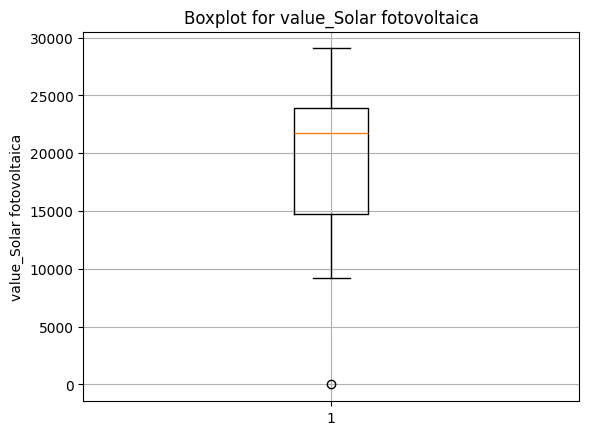

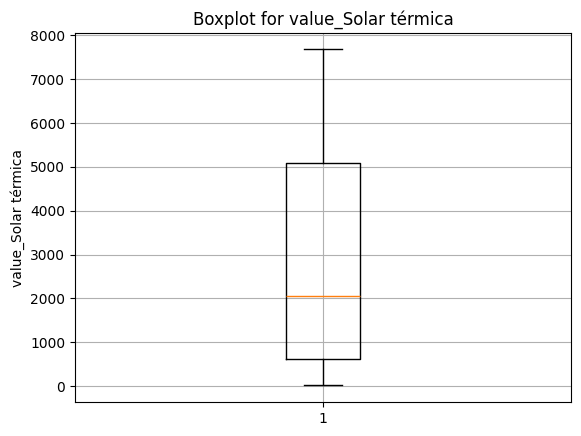

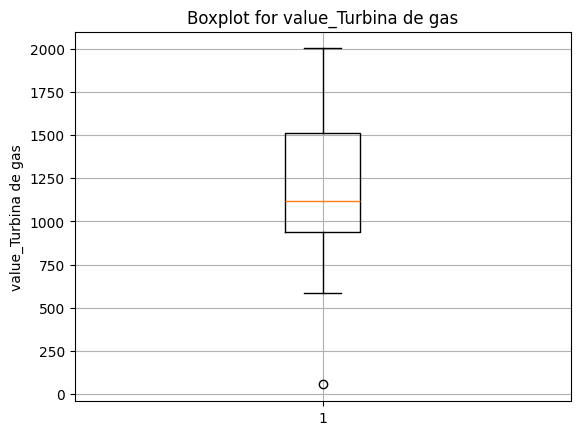

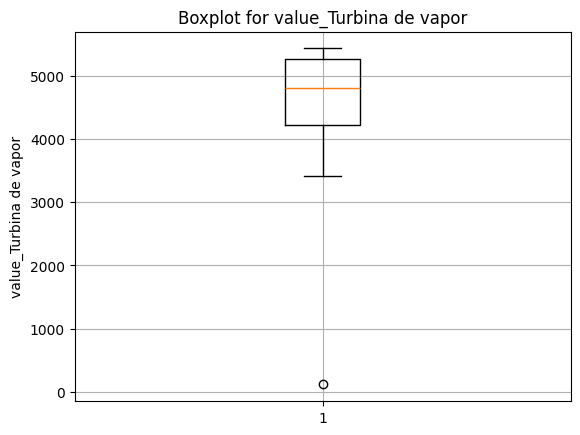

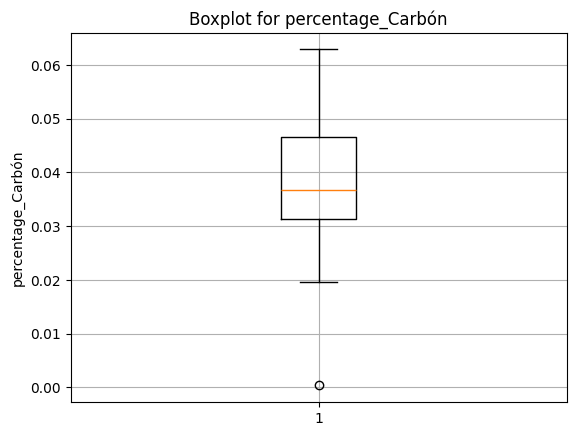

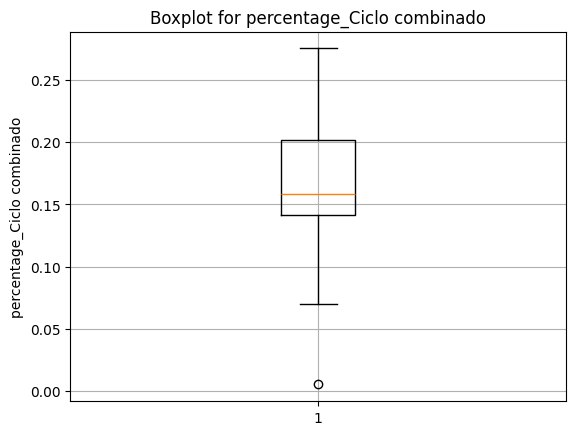

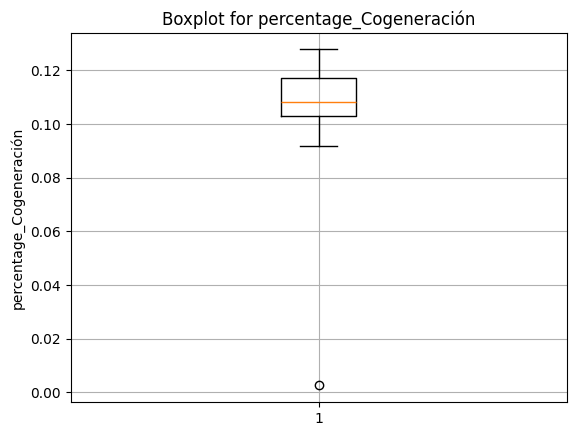

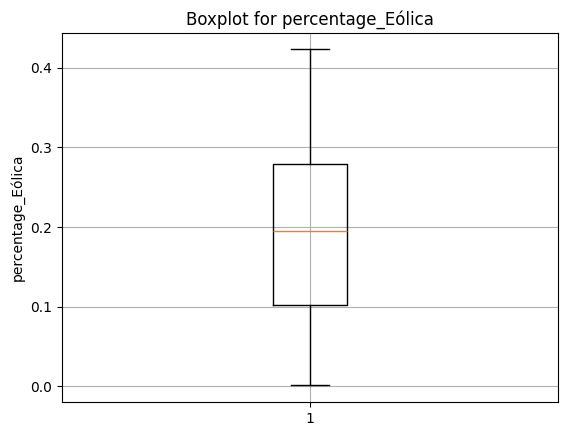

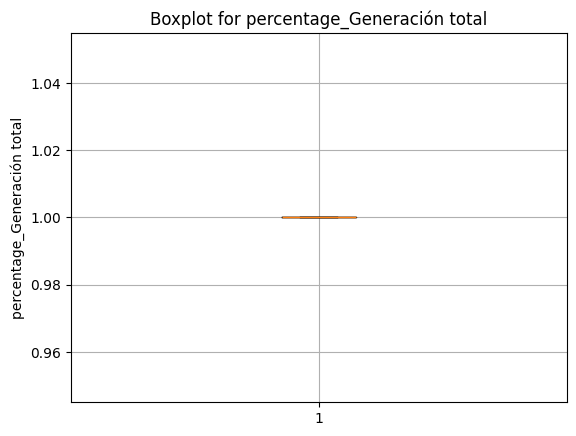

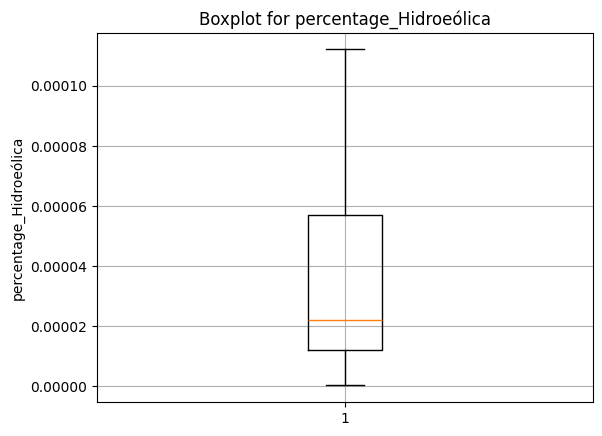

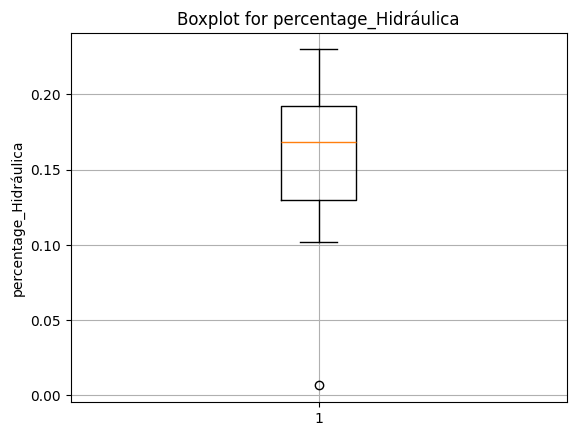

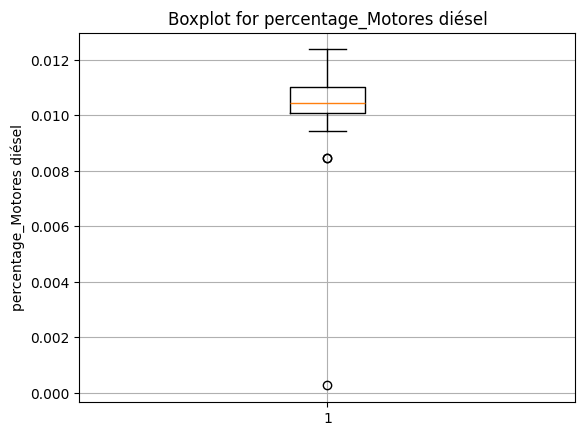

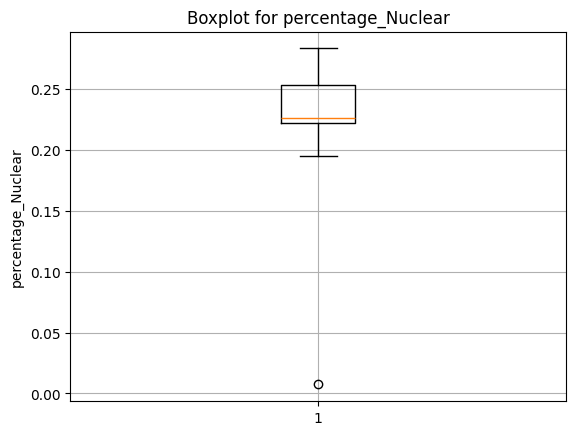

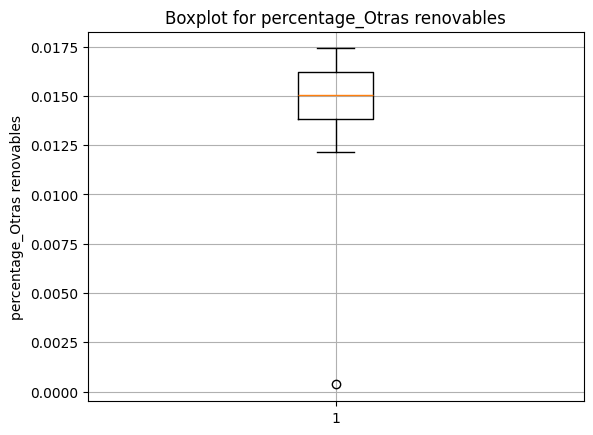

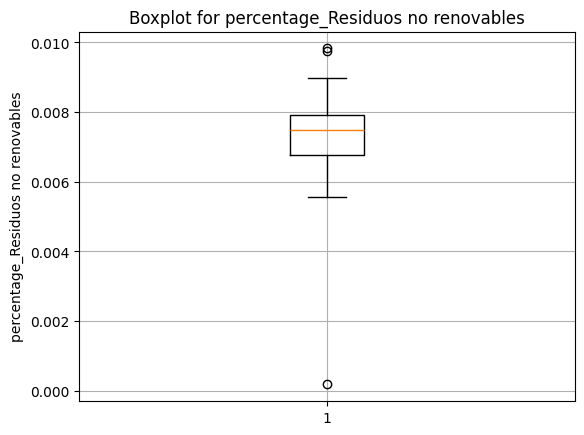

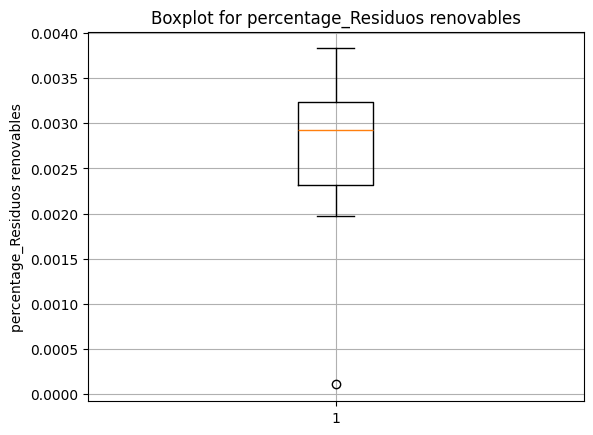

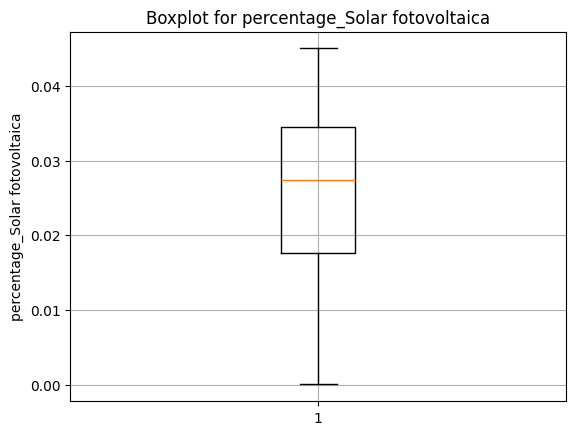

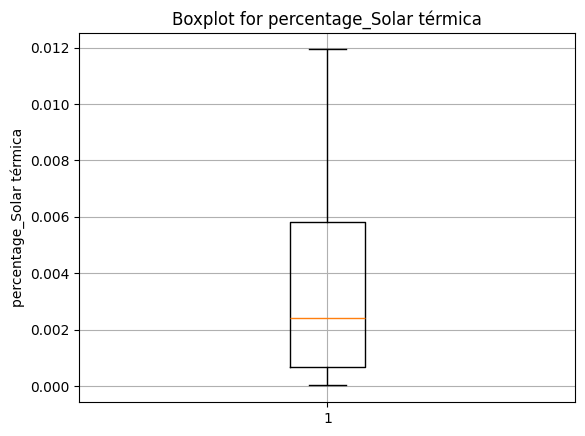

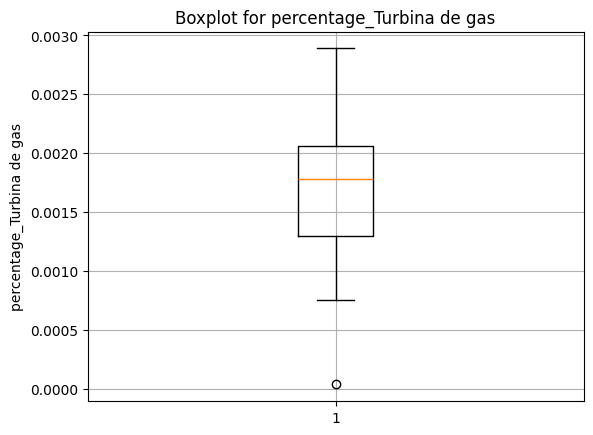

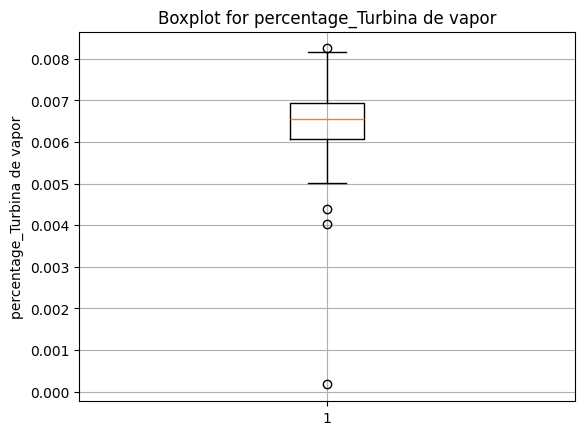

⚠️ Outliers detected in the following columns:
  - percentage_Carbón
  - percentage_Ciclo combinado
  - percentage_Cogeneración
  - percentage_Hidráulica
  - percentage_Motores diésel
  - percentage_Nuclear
  - percentage_Otras renovables
  - percentage_Residuos no renovables
  - percentage_Residuos renovables
  - percentage_Turbina de gas
  - percentage_Turbina de vapor
  - value_Carbón
  - value_Ciclo combinado
  - value_Cogeneración
  - value_Generación total
  - value_Hidráulica
  - value_Motores diésel
  - value_Nuclear
  - value_Otras renovables
  - value_Residuos no renovables
  - value_Residuos renovables
  - value_Solar fotovoltaica
  - value_Turbina de gas
  - value_Turbina de vapor

📌 Treatment applied: Replaced Z-score outliers (>3σ) with NaN.


In [10]:
# Check daily data for outliers values
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Assume daily_pivot is already prepared as described earlier
# Exclude 'datetime' column
data = daily_pivot.select_dtypes(include=[np.number])

# -------------------------
# 1. Z-score Method
# -------------------------
z_scores = np.abs(stats.zscore(data, nan_policy='omit'))
z_outliers = (z_scores > 3)

z_outlier_cols = data.columns[(z_outliers.sum(axis=0) > 0)].tolist()

# -------------------------
# 2. IQR Method
# -------------------------
iqr_outlier_cols = []
for col in data.columns:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = data[(data[col] < lower) | (data[col] > upper)]
    if not outliers.empty:
        iqr_outlier_cols.append(col)

# -------------------------
# 3. Boxplot Visualization
# -------------------------
for col in data.columns:
    plt.figure()
    plt.boxplot(data[col].dropna())
    plt.title(f'Boxplot for {col}')
    plt.ylabel(col)
    plt.grid(True)
    plt.show()

# -------------------------
# 4. Summary Output
# -------------------------
if not z_outlier_cols and not iqr_outlier_cols:
    print("✅ No outliers found using Z-score or IQR methods.")
else:
    all_outlier_cols = sorted(set(z_outlier_cols + iqr_outlier_cols))
    print("⚠️ Outliers detected in the following columns:")
    for col in all_outlier_cols:
        print(f"  - {col}")

    # Optional treatment (e.g., replacing with NaN or clipping)
    # Example: Replace extreme Z-score outliers with NaN
    for col in all_outlier_cols:
        daily_pivot.loc[z_outliers[:, data.columns.get_loc(col)], col] = np.nan

    print("\n📌 Treatment applied: Replaced Z-score outliers (>3σ) with NaN.")

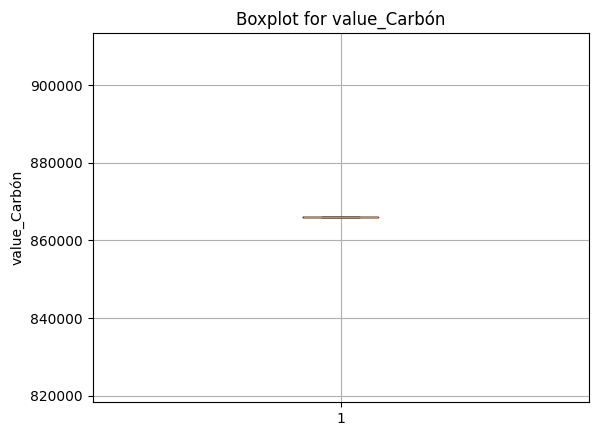

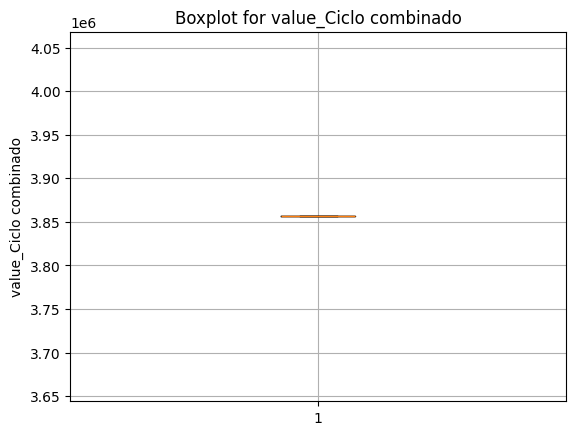

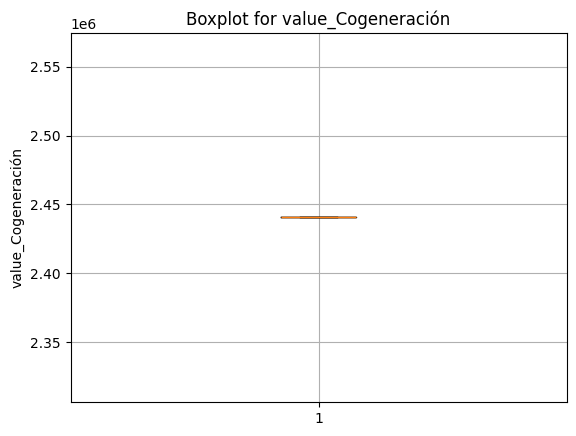

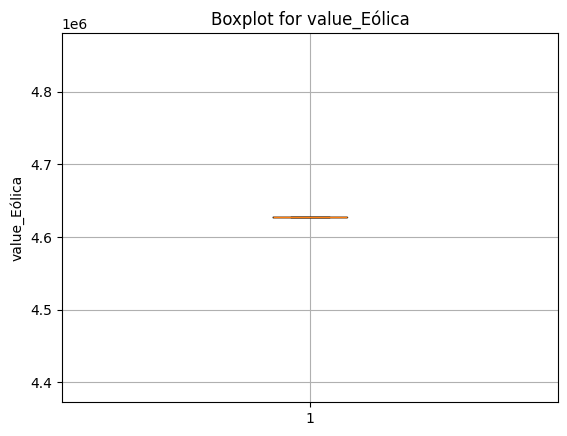

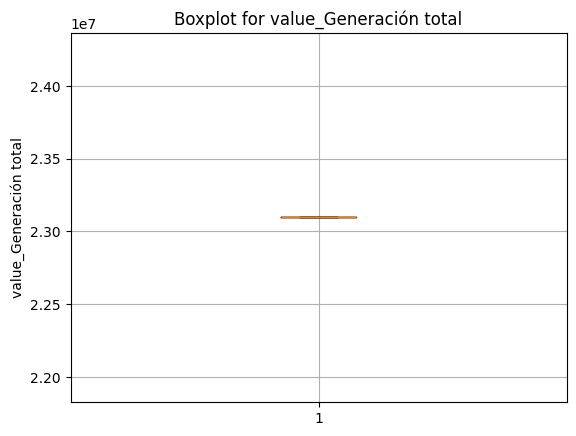

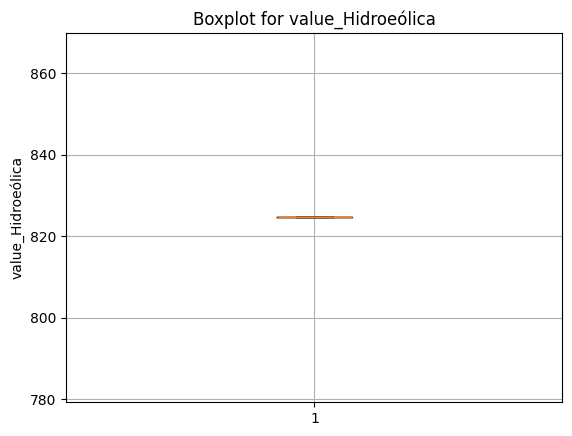

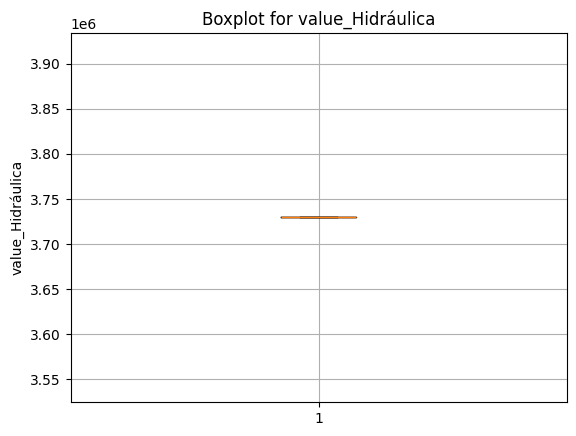

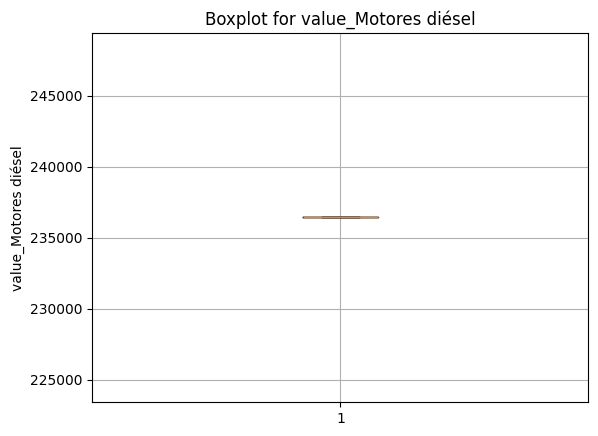

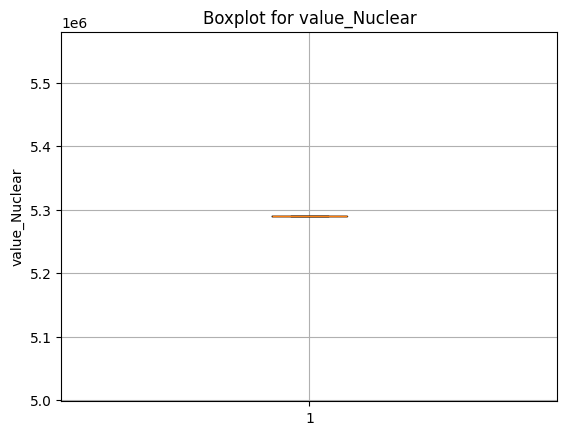

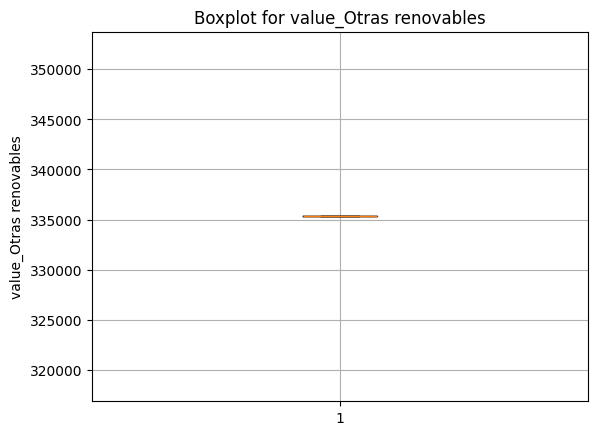

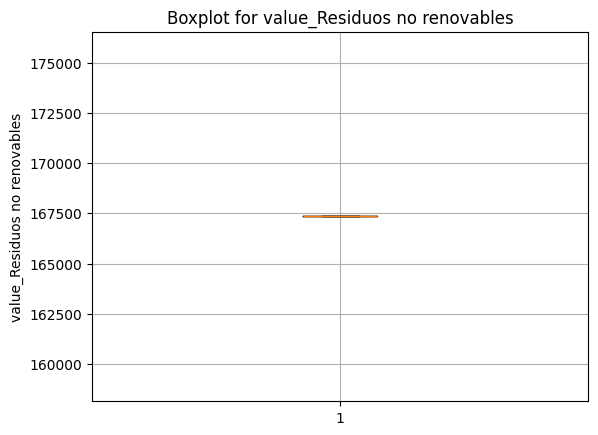

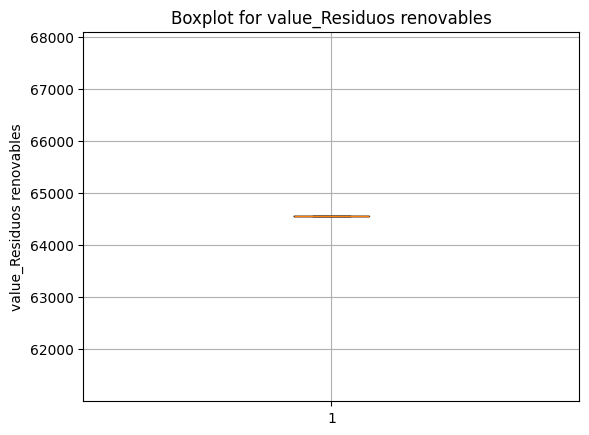

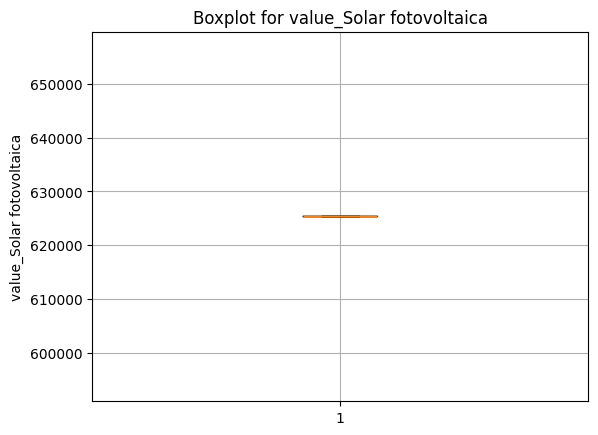

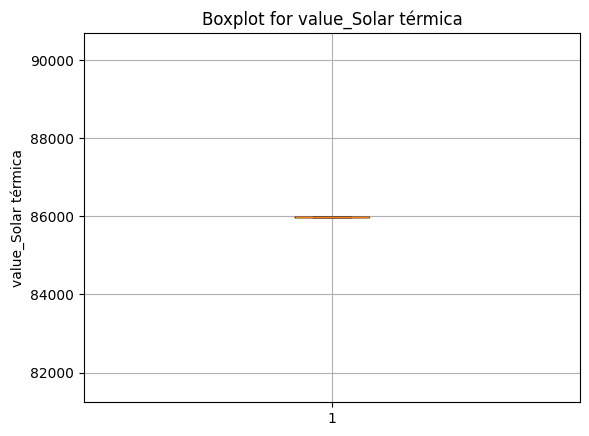

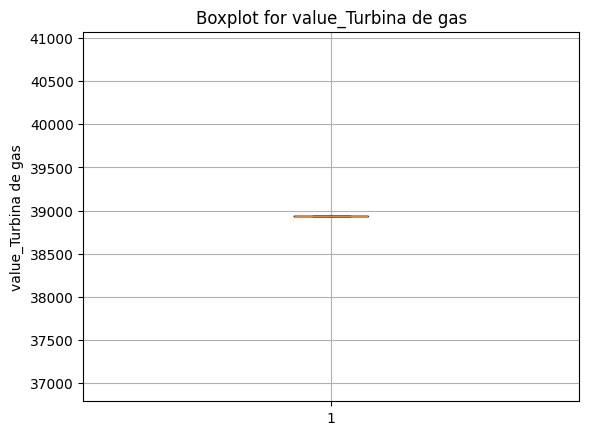

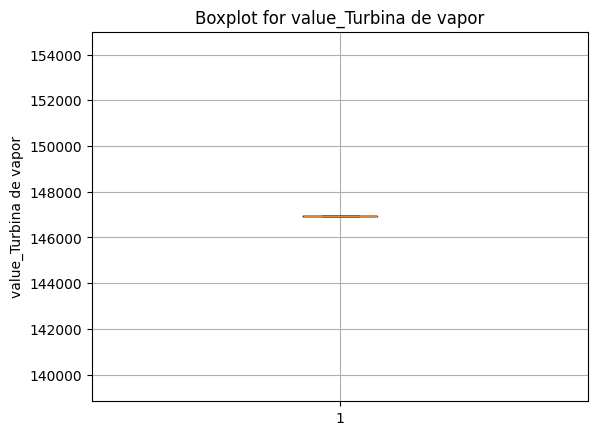

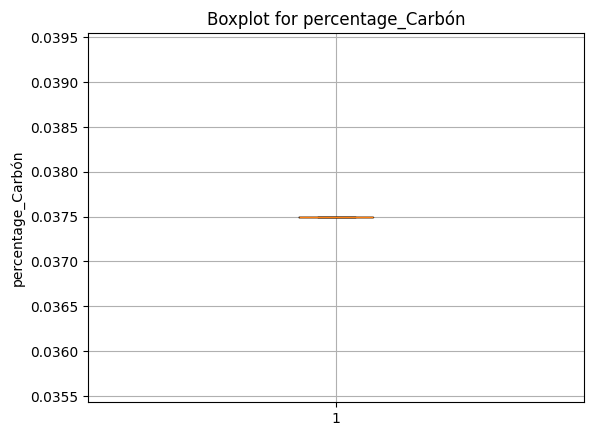

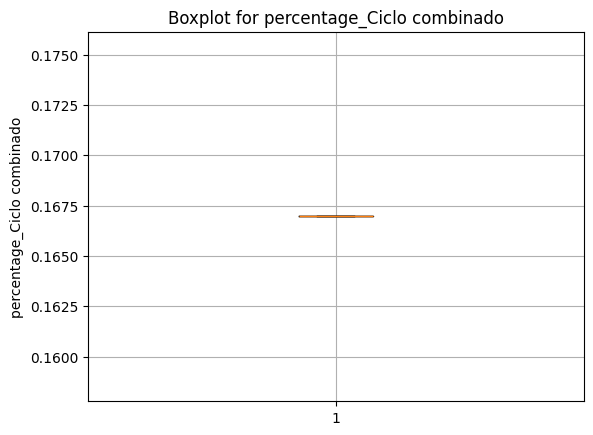

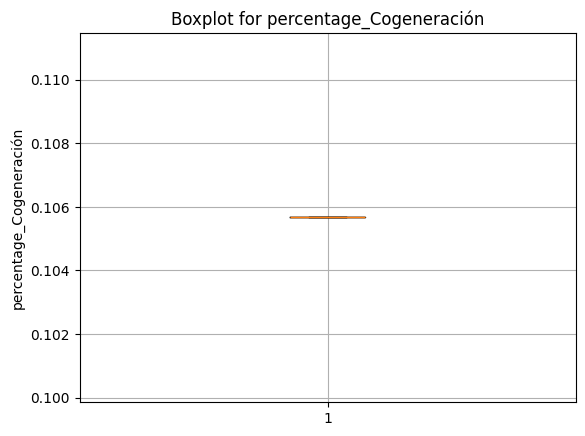

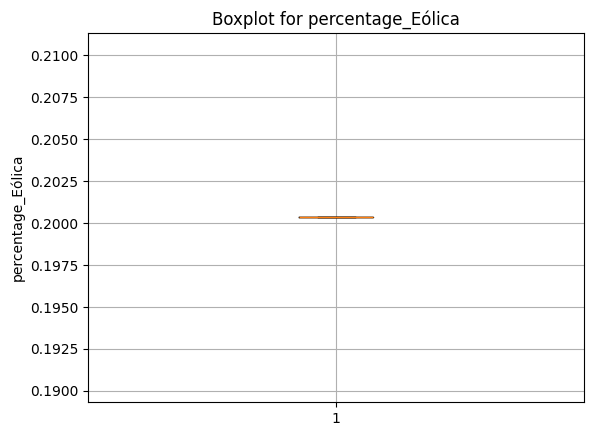

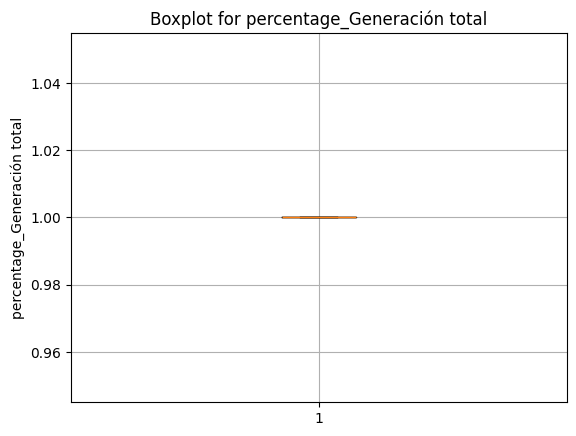

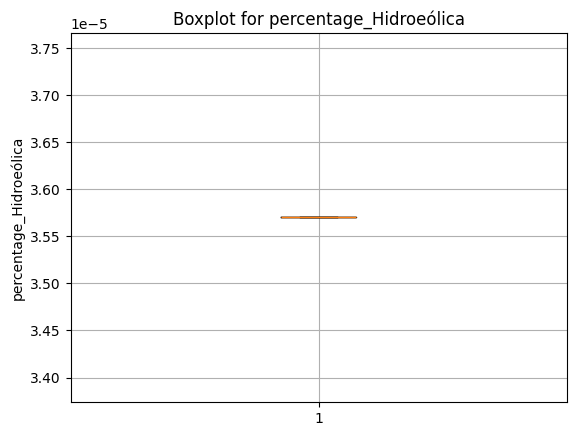

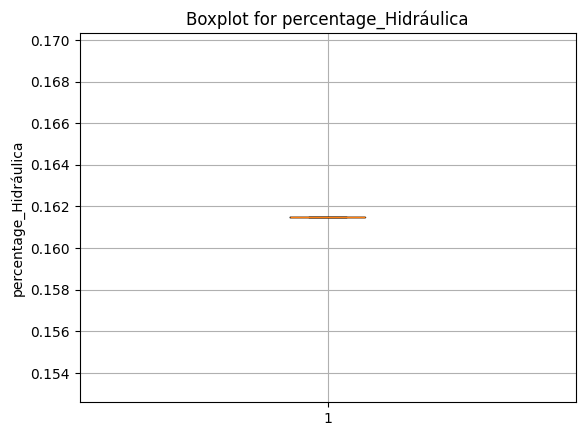

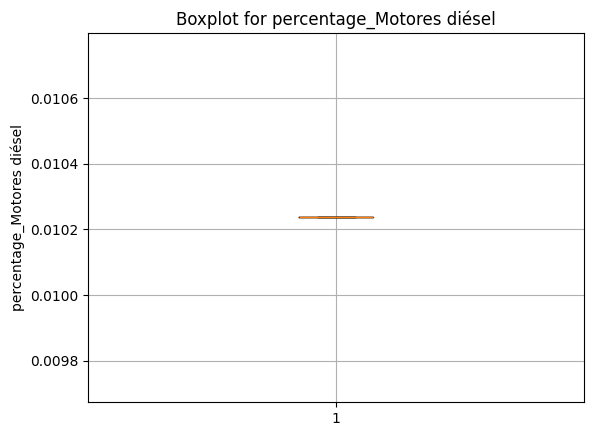

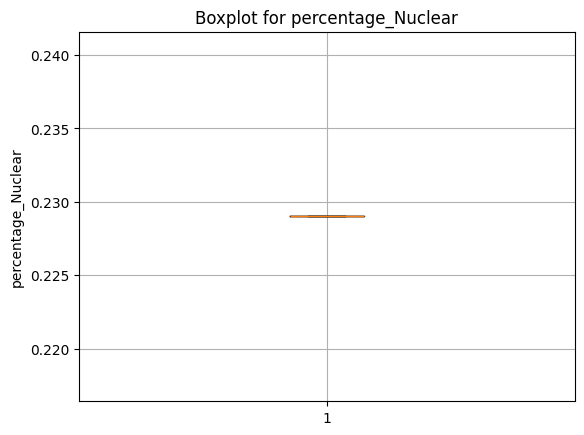

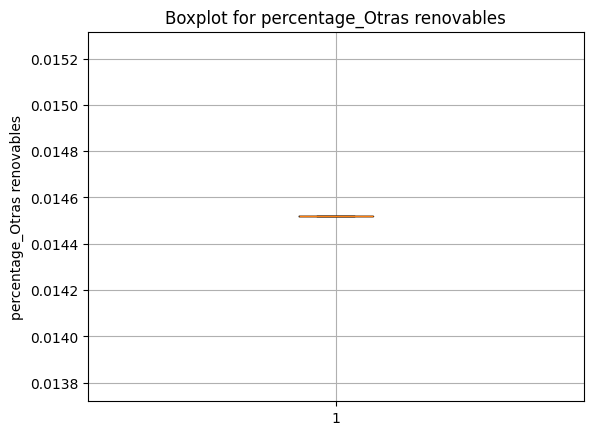

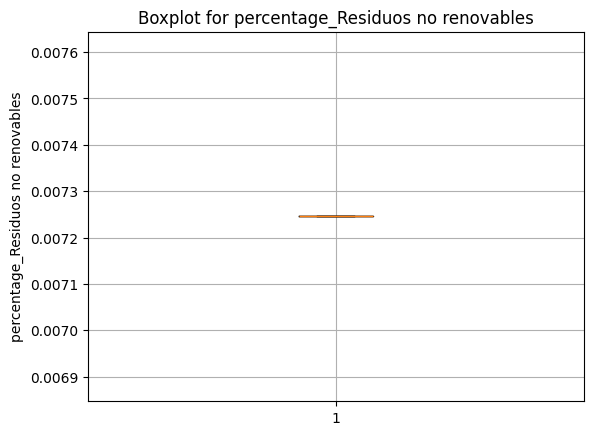

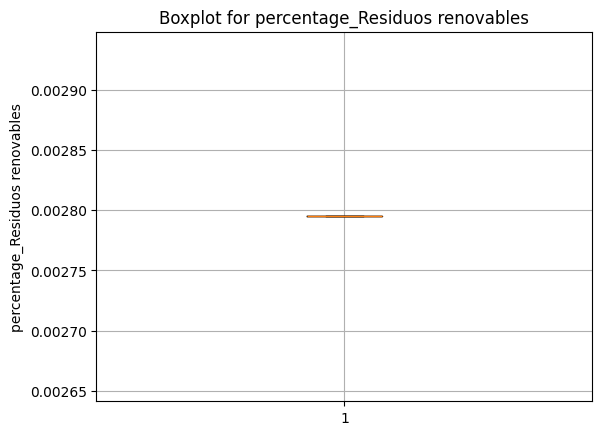

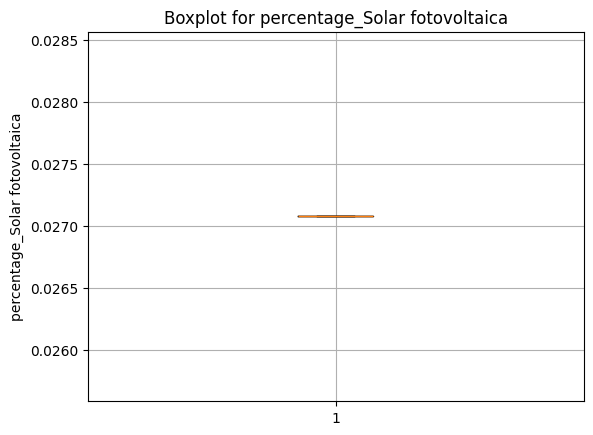

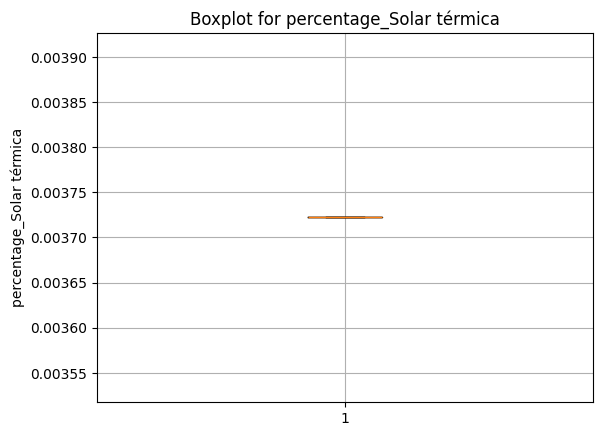

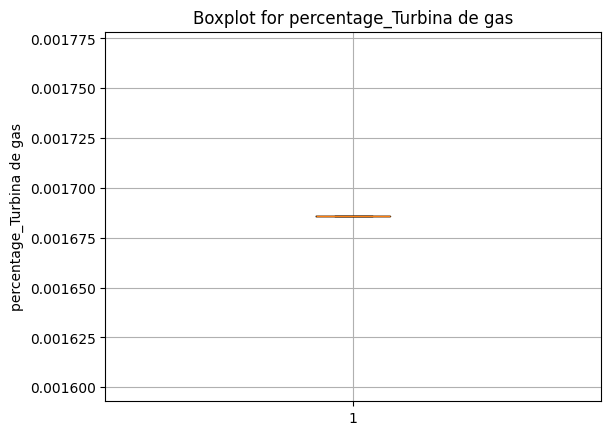

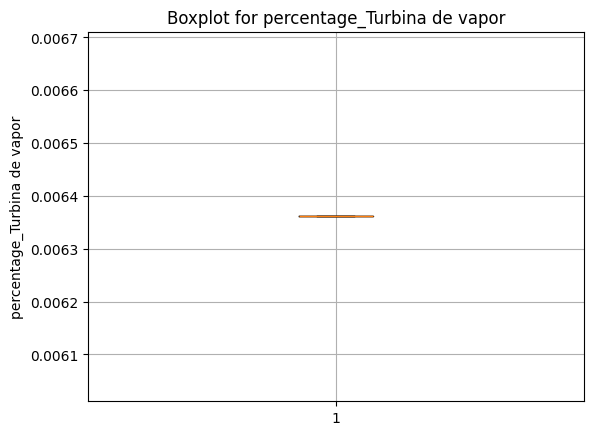

✅ No outliers found in monthly data using Z-score or IQR methods.


In [11]:
# Check for outliers in monthly data
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Assume monthly_pivot is already prepared
# Remove 'month' column for numeric analysis
data = monthly_pivot.select_dtypes(include=[np.number])

# -------------------------
# 1. Z-score Method
# -------------------------
z_scores = np.abs(stats.zscore(data, nan_policy='omit'))
z_outliers = (z_scores > 3)

z_outlier_cols = data.columns[(z_outliers.sum(axis=0) > 0)].tolist()

# -------------------------
# 2. IQR Method
# -------------------------
iqr_outlier_cols = []
for col in data.columns:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = data[(data[col] < lower) | (data[col] > upper)]
    if not outliers.empty:
        iqr_outlier_cols.append(col)

# -------------------------
# 3. Boxplot Visualization
# -------------------------
for col in data.columns:
    plt.figure()
    plt.boxplot(data[col].dropna())
    plt.title(f'Boxplot for {col}')
    plt.ylabel(col)
    plt.grid(True)
    plt.show()

# -------------------------
# 4. Summary Output
# -------------------------
if not z_outlier_cols and not iqr_outlier_cols:
    print("✅ No outliers found in monthly data using Z-score or IQR methods.")
else:
    all_outlier_cols = sorted(set(z_outlier_cols + iqr_outlier_cols))
    print("⚠️ Outliers detected in the following columns of monthly data:")
    for col in all_outlier_cols:
        print(f"  - {col}")

    # Optional treatment: Replace Z-score outliers with NaN
    for col in all_outlier_cols:
        monthly_pivot.loc[z_outliers[:, data.columns.get_loc(col)], col] = np.nan

    print("\n📌 Treatment applied: Z-score outliers (>3σ) replaced with NaN in monthly data.")

In [12]:
# Check data for duplicate values in daily_pivot
duplicates = daily_pivot.duplicated()

if not duplicates.any():
    print("✅ No duplicates found in daily data.")
else:
    num_duplicates = duplicates.sum()
    print(f"⚠️ {num_duplicates} duplicate rows found in daily data.")
    daily_pivot = daily_pivot.drop_duplicates()
    print("🧹 Treatment applied: Duplicate rows were removed from daily data.")

✅ No duplicates found in daily data.


In [13]:
# Check data for duplicate values in monthly_pivot
duplicates = monthly_pivot.duplicated()

if not duplicates.any():
    print("✅ No duplicates found in monthly data.")
else:
    num_duplicates = duplicates.sum()
    print(f"⚠️ {num_duplicates} duplicate rows found in monthly data.")
    monthly_pivot = monthly_pivot.drop_duplicates()
    print("🧹 Treatment applied: Duplicate rows were removed from monthly data.")

✅ No duplicates found in monthly data.


In [14]:
# Check for NaN/null values in daily_pivot
null_counts = daily_pivot.isnull().sum()
total_null_rows = daily_pivot.isnull().any(axis=1).sum()

if total_null_rows == 0:
    print("✅ No NaN/null values found in daily data.")
else:
    print("⚠️ NaN/null values found in the following columns of daily data:")
    print(null_counts[null_counts > 0])
    print(f"🧹 Total rows with NaNs to be removed: {total_null_rows}")

    # Drop rows with any NaNs
    daily_pivot = daily_pivot.dropna()
    print("📌 Treatment applied: Rows with NaN values were dropped from daily data.")

⚠️ NaN/null values found in the following columns of daily data:
value_Cogeneración                   1
value_Generación total               1
value_Hidráulica                     1
value_Motores diésel                 1
value_Nuclear                        1
value_Otras renovables               1
value_Residuos no renovables         1
value_Residuos renovables            1
value_Solar térmica                  1
value_Turbina de vapor               1
percentage_Cogeneración              1
percentage_Hidráulica                1
percentage_Motores diésel            1
percentage_Nuclear                   1
percentage_Otras renovables          1
percentage_Residuos no renovables    1
percentage_Residuos renovables       1
percentage_Solar térmica             1
percentage_Turbina de vapor          1
dtype: int64
🧹 Total rows with NaNs to be removed: 2
📌 Treatment applied: Rows with NaN values were dropped from daily data.


In [15]:
# Check for NaN/null values in monthly_pivot
null_counts = monthly_pivot.isnull().sum()
total_null_rows = monthly_pivot.isnull().any(axis=1).sum()

if total_null_rows == 0:
    print("✅ No NaN/null values found in monthly data.")
else:
    print("⚠️ NaN/null values found in the following columns of monthly data:")
    print(null_counts[null_counts > 0])
    print(f"🧹 Total rows with NaNs to be removed: {total_null_rows}")

    # Drop rows with any NaNs
    monthly_pivot = monthly_pivot.dropna()
    print("📌 Treatment applied: Rows with NaN values were dropped from monthly data.")

✅ No NaN/null values found in monthly data.


In [16]:
# Information about daily_pivot
daily_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, 1 to 29
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype                    
---  ------                             --------------  -----                    
 0   datetime                           29 non-null     datetime64[ns, UTC+01:00]
 1   value_Carbón                       29 non-null     float64                  
 2   value_Ciclo combinado              29 non-null     float64                  
 3   value_Cogeneración                 29 non-null     float64                  
 4   value_Eólica                       29 non-null     float64                  
 5   value_Generación total             29 non-null     float64                  
 6   value_Hidroeólica                  29 non-null     float64                  
 7   value_Hidráulica                   29 non-null     float64                  
 8   value_Motores diésel               29 non-null     float64                  


In [17]:
# Descriptive statistics about daily_pivot
daily_pivot.describe()

,value_Carbón,value_Ciclo combinado,value_Cogeneración,value_Eólica,value_Generación total,value_Hidroeólica,value_Hidráulica,value_Motores diésel,value_Nuclear,value_Otras renovables,...,percentage_Hidráulica,percentage_Motores diésel,percentage_Nuclear,percentage_Otras renovables,percentage_Residuos no renovables,percentage_Residuos renovables,percentage_Solar fotovoltaica,percentage_Solar térmica,percentage_Turbina de gas,percentage_Turbina de vapor
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,...,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,28480.408207,125368.065103,79344.714103,152137.659966,730967.031966,27.255172,120125.119828,7665.935448,170615.376379,10880.059552,...,0.166151,0.010538,0.235312,0.014961,0.007483,0.002837,0.027937,0.003952,0.001739,0.006544
std,8852.962684,36072.283640,3313.262624,86487.287663,65622.576502,25.147957,22336.034863,567.916587,542.947879,920.774124,...,0.036695,0.000897,0.022023,0.001472,0.001049,0.000529,0.009670,0.003818,0.000524,0.000859
min,13528.944000,54644.870000,73089.797000,45587.571000,602982.974000,0.200000,80016.253000,6117.604000,167839.564000,8407.882000,...,0.106207,0.008457,0.194784,0.012143,0.005550,0.001970,0.010971,0.000020,0.000755,0.004386
25%,22964.568000,105270.559000,77322.202000,77426.389000,672539.279000,10.860000,103275.679000,7329.940000,170608.729000,10499.567000,...,0.132299,0.010117,0.222070,0.013839,0.006913,0.002354,0.019721,0.000688,0.001316,0.006278
50%,27942.786000,119045.523000,78871.247000,135416.026000,756045.101000,19.093000,126556.491000,7750.610000,170720.825000,10871.684000,...,0.169486,0.010430,0.225906,0.015063,0.007554,0.002922,0.028072,0.002524,0.001783,0.006593
75%,34701.108000,145516.904000,81302.220000,206430.710000,768769.911000,40.872000,139703.137000,8026.247000,170794.414000,11445.010000,...,0.195077,0.011042,0.253627,0.016188,0.007931,0.003230,0.035480,0.005882,0.002096,0.006945
max,47491.696000,210318.037000,86063.969000,347001.229000,861669.177000,83.152000,159171.675000,8589.298000,170888.033000,12879.051000,...,0.229885,0.012374,0.283002,0.017400,0.009826,0.003828,0.045006,0.011934,0.002889,0.008251


In [18]:
# Information about monthly_pivot
monthly_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype    
---  ------                             --------------  -----    
 0   month                              1 non-null      period[M]
 1   value_Carbón                       1 non-null      float64  
 2   value_Ciclo combinado              1 non-null      float64  
 3   value_Cogeneración                 1 non-null      float64  
 4   value_Eólica                       1 non-null      float64  
 5   value_Generación total             1 non-null      float64  
 6   value_Hidroeólica                  1 non-null      float64  
 7   value_Hidráulica                   1 non-null      float64  
 8   value_Motores diésel               1 non-null      float64  
 9   value_Nuclear                      1 non-null      float64  
 10  value_Otras renovables             1 non-null      float64  
 11  value_Residuos no renovables       1

In [19]:
# Descriptive statistics about monthly_pivot
monthly_pivot.describe()

,value_Carbón,value_Ciclo combinado,value_Cogeneración,value_Eólica,value_Generación total,value_Hidroeólica,value_Hidráulica,value_Motores diésel,value_Nuclear,value_Otras renovables,...,percentage_Hidráulica,percentage_Motores diésel,percentage_Nuclear,percentage_Otras renovables,percentage_Residuos no renovables,percentage_Residuos renovables,percentage_Solar fotovoltaica,percentage_Solar térmica,percentage_Turbina de gas,percentage_Turbina de vapor
count,1.000,1.000,1.000,1.000,1.000000e+00,1.00,1.000,1.000,1.000,1.000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mean,865887.004,3856118.343,2440531.494,4626864.398,2.309634e+07,824.55,3729343.838,236418.961,5289146.024,335311.749,...,0.161469,0.010236,0.229004,0.014518,0.007245,0.002795,0.027075,0.003722,0.001686,0.006361
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,865887.004,3856118.343,2440531.494,4626864.398,2.309634e+07,824.55,3729343.838,236418.961,5289146.024,335311.749,...,0.161469,0.010236,0.229004,0.014518,0.007245,0.002795,0.027075,0.003722,0.001686,0.006361
25%,865887.004,3856118.343,2440531.494,4626864.398,2.309634e+07,824.55,3729343.838,236418.961,5289146.024,335311.749,...,0.161469,0.010236,0.229004,0.014518,0.007245,0.002795,0.027075,0.003722,0.001686,0.006361
50%,865887.004,3856118.343,2440531.494,4626864.398,2.309634e+07,824.55,3729343.838,236418.961,5289146.024,335311.749,...,0.161469,0.010236,0.229004,0.014518,0.007245,0.002795,0.027075,0.003722,0.001686,0.006361
75%,865887.004,3856118.343,2440531.494,4626864.398,2.309634e+07,824.55,3729343.838,236418.961,5289146.024,335311.749,...,0.161469,0.010236,0.229004,0.014518,0.007245,0.002795,0.027075,0.003722,0.001686,0.006361
max,865887.004,3856118.343,2440531.494,4626864.398,2.309634e+07,824.55,3729343.838,236418.961,5289146.024,335311.749,...,0.161469,0.010236,0.229004,0.014518,0.007245,0.002795,0.027075,0.003722,0.001686,0.006361


## Task 3: Data Visualization and Insights Extraction

This code transforms raw time-series (hourly or daily) data into insightful visualizations by aggregating daily generation values by different time periods (day or week) and presenting them by technology type.

__Input:__
Dataframe 'df' with columns:
- datetime
- value
- percentage
- technology

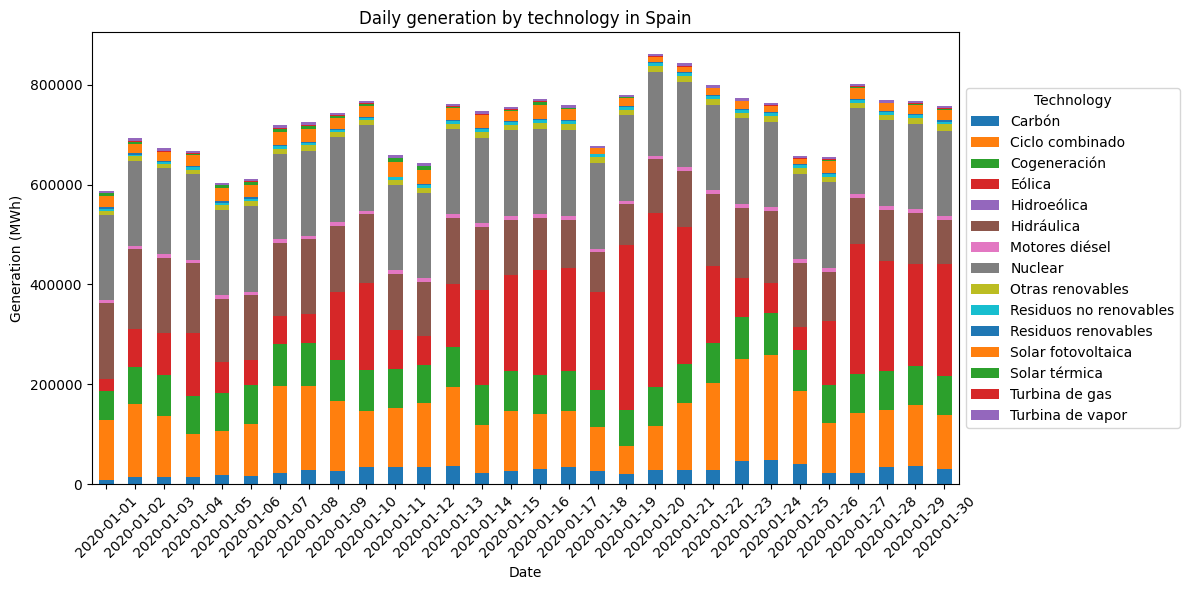

In [20]:
# Daily Energy Generation Bar Graph by Technology
# Exclusive of last date in range
# This sums hourly values for each day, in case hourly data becomes available in this widget in the future

import matplotlib.pyplot as plt

df["date"] = pd.to_datetime(df["datetime"]).dt.date

# Remove all rows corresponding to the last date in the dataset (the values are abnormally low)
df_truncated = df[df["date"] != df["date"].max()]

# Remove monthly sum values, which are the larger of two values for each tech on the 1st of the month
# Sort so that the larger values come last, and keep only the first
df_truncated = df_truncated.sort_values(["technology", "date", "value"], ascending=[True, True, True])
df_clean = df_truncated.drop_duplicates(subset=["date", "technology"], keep="first")

pivot_df = df_clean.pivot_table(
    index="date",
    columns="technology",
    values="value",
    aggfunc="sum",
    fill_value=0
    )

pivot_df_indiv = pivot_df.drop(columns="Generación total", errors="ignore")

pivot_df_indiv.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    title=f"Daily generation by technology in Spain",
    )

plt.xlabel("Date")
plt.ylabel("Generation (MWh)")
plt.xticks(rotation=45)
plt.legend(title="Technology", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()

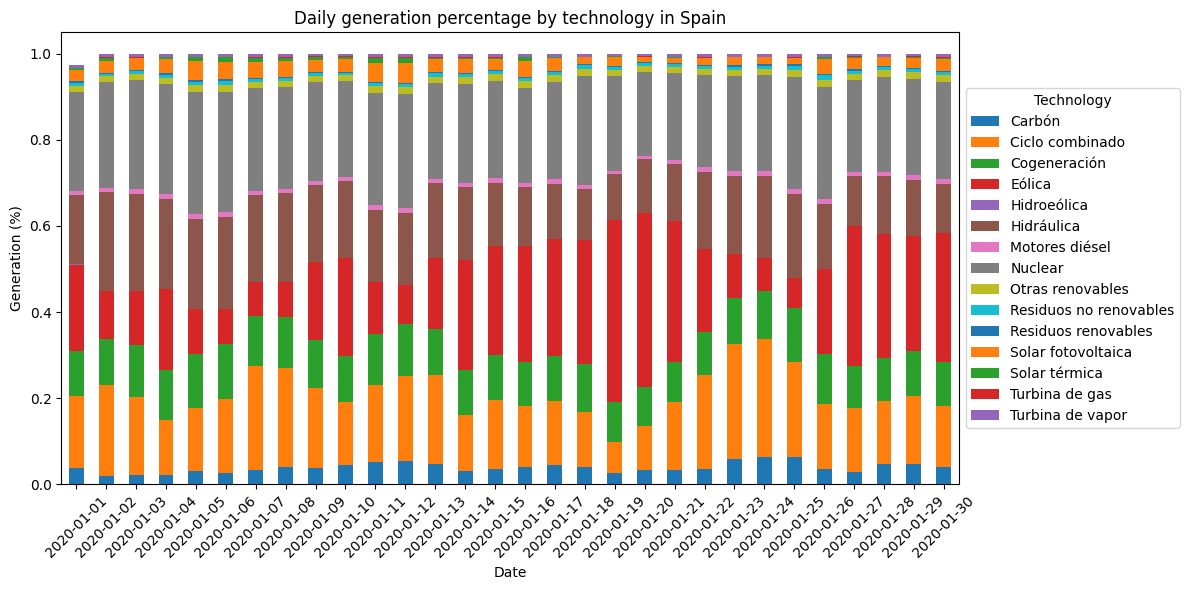

In [21]:
# Daily Energy Generation Percentage Bar Graph by Technology
# Exclusive of last date in range
# This sums hourly percentages for each day, in case hourly data becomes available in this widget in the future

import matplotlib.pyplot as plt

df["date"] = pd.to_datetime(df["datetime"]).dt.date

# Remove all rows corresponding to the last date in the dataset (the values are abnormally low)
df_truncated = df[df["date"] != df["date"].max()]

# Remove monthly sum percentages, which are the smaller of two values for each tech on the 1st of the month
# Sort so that the smaller percentages come last, and keep only the first
df_truncated = df_truncated.sort_values(["technology", "date", "percentage"], ascending=[True, True, False])
df_clean = df_truncated.drop_duplicates(subset=["date", "technology"], keep="first")

pivot_df = df_clean.pivot_table(
    index="date",
    columns="technology",
    values="percentage",
    aggfunc="sum",
    fill_value=0
    )

pivot_df_indiv = pivot_df.drop(columns="Generación total", errors="ignore")

pivot_df_indiv.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    title=f"Daily generation percentage by technology in Spain",
    )

plt.xlabel("Date")
plt.ylabel("Generation (%)")
plt.xticks(rotation=45)
plt.legend(title="Technology", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()


<ipython-input-22-ca607491a598>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["week"] = pd.to_datetime(df_clean["date"]).dt.to_period("W-MON")


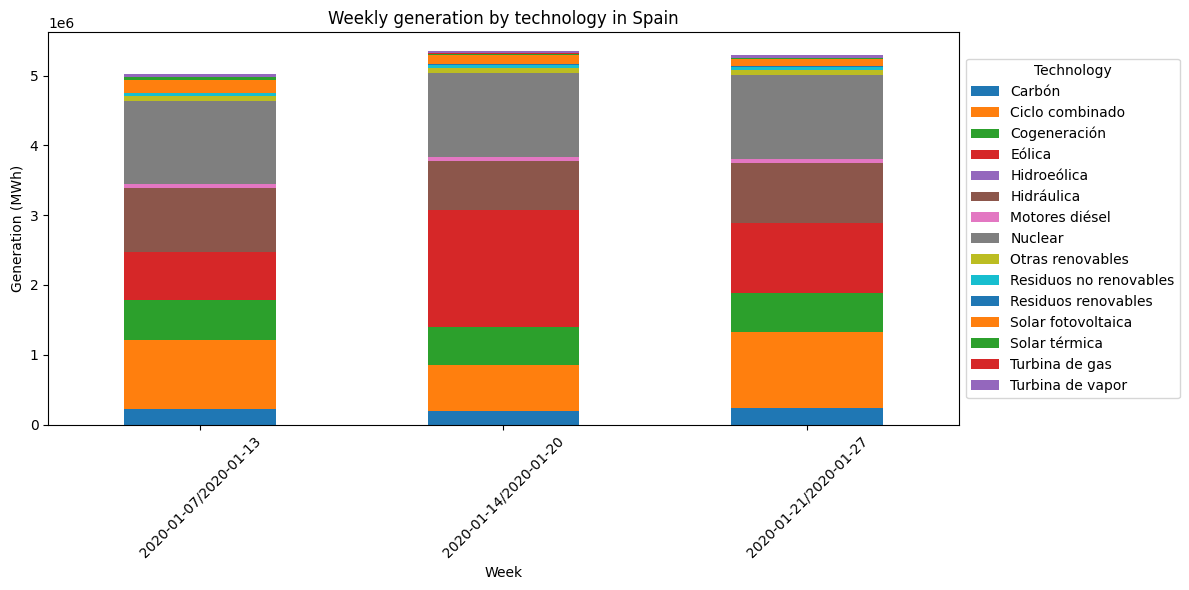

In [22]:
# Weekly Energy Generation Share Bar Graph by Technology
# exclusive of last date in range
# This aggregates percentage values for complete weeks only (starting on Mondays)

import matplotlib.pyplot as plt

df["date"] = pd.to_datetime(df["datetime"]).dt.date

# Remove all rows corresponding to the last date in the dataset (the values are abnormally low)
df_truncated = df[df["date"] != df["date"].max()]

# Remove monthly sum values, which are the larger of two values for each tech on the 1st of the month
# Sort so that the larger values come last, and keep only the first
df_truncated = df_truncated.sort_values(["technology", "date", "value"], ascending=[True, True, True])
df_clean = df_truncated.drop_duplicates(subset=["date", "technology"], keep="first")

# Add weekly period starting on Monday
df_clean["week"] = pd.to_datetime(df_clean["date"]).dt.to_period("W-MON")

# Count number of days per week
week_counts = df_clean.groupby("week")["date"].nunique()
full_weeks = week_counts[week_counts == 7].index

# Keep only data from full weeks
df_clean = df_clean[df_clean["week"].isin(full_weeks)]

# Pivot the cleaned dataframe
pivot_df = df_clean.pivot_table(
    index="week",
    columns="technology",
    values="value",
    aggfunc="sum",
    fill_value=0
)

pivot_df_indiv = pivot_df.drop(columns="Generación total", errors="ignore")

pivot_df_indiv.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    title=f"Weekly generation by technology in Spain",
)

plt.xlabel("Week")
plt.ylabel("Generation (MWh)")
plt.xticks(rotation=45)
plt.legend(title="Technology", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()

<ipython-input-23-bdb53a576d2c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["week"] = pd.to_datetime(df_clean["date"]).dt.to_period("W-MON")


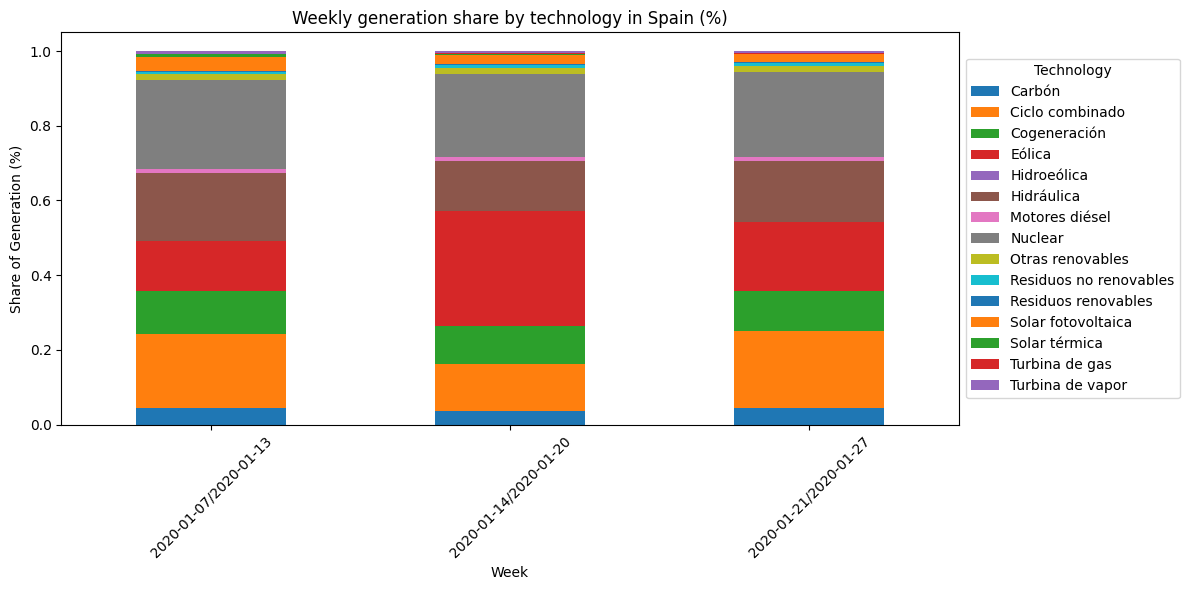

In [23]:
# Weekly Energy Generation Share Bar Graph by Technology (Percentage)
# exclusive of last date in range
# This aggregates percentage values for complete weeks only (starting on Mondays)

import matplotlib.pyplot as plt

df["date"] = pd.to_datetime(df["datetime"]).dt.date

# Remove all rows corresponding to the last date in the dataset (the values are abnormally low)
df_truncated = df[df["date"] != df["date"].max()]

# Remove monthly sum percentages, which are the smaller of two values for each tech on the 1st of the month
# Sort so that the smaller percentages come last, and keep only the first
df_truncated = df_truncated.sort_values(["technology", "date", "percentage"], ascending=[True, True, False])
df_clean = df_truncated.drop_duplicates(subset=["date", "technology"], keep="first")

# Add weekly period starting on Monday
df_clean["week"] = pd.to_datetime(df_clean["date"]).dt.to_period("W-MON")

# Count number of days per week
week_counts = df_clean.groupby("week")["date"].nunique()
full_weeks = week_counts[week_counts == 7].index

# Keep only data from full weeks
df_clean = df_clean[df_clean["week"].isin(full_weeks)]

# Pivot the cleaned dataframe
pivot_df = df_clean.pivot_table(
    index="week",
    columns="technology",
    values="percentage",
    aggfunc="mean",
    fill_value=0
)

pivot_df_indiv = pivot_df.drop(columns="Generación total", errors="ignore")

pivot_df_indiv.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    title=f"Weekly generation share by technology in Spain (%)",
)

plt.xlabel("Week")
plt.ylabel("Share of Generation (%)")
plt.xticks(rotation=45)
plt.legend(title="Technology", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()



Select a technology to generate the chart:

1. Carbón
2. Ciclo combinado
3. Cogeneración
4. Eólica
5. Generación total
6. Hidroeólica
7. Hidráulica
8. Motores diésel
9. Nuclear
10. Otras renovables
11. Residuos no renovables
12. Residuos renovables
13. Solar fotovoltaica
14. Solar térmica
15. Turbina de gas
16. Turbina de vapor

Enter the number of the selected technology: 7

You selected: Hidráulica


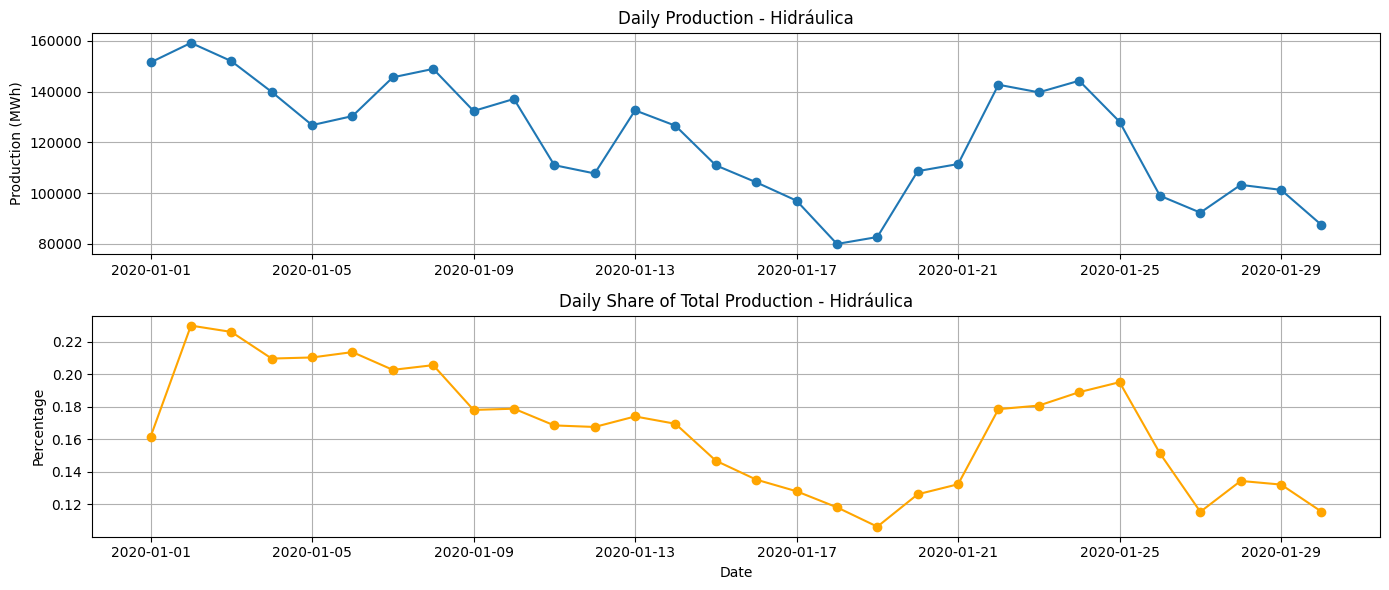

In [24]:
# Daily Energy Generation Line Charts by Technology
# This script lets the user select a technology from the dataset and shows two line charts:
# one for daily total production (in MWh) and one for average daily percentage.
# It groups and sums values by day to visualize trends over time.

import pandas as pd
import matplotlib.pyplot as plt

df["date"] = pd.to_datetime(df["datetime"]).dt.date

# Get unique technologies and create the dynamic menu
tech_list = sorted(df['technology'].unique())

df_trunc = df[df["date"] != df["date"].max()]

df_trunc_val = df_trunc.sort_values(["technology", "date", "value"], ascending=[True, True, True])
df_trunc_val = df_trunc_val.drop_duplicates(subset=["date", "technology"], keep="first")

df_trunc_perc = df_trunc.sort_values(["technology", "date", "percentage"], ascending=[True, True, False])
df_trunc_perc = df_trunc_perc.drop_duplicates(subset=["date", "technology"], keep="first")

# Menu and input loop
selected_tech = None
while selected_tech is None:
    print("\nSelect a technology to generate the chart:\n")
    for idx, tech in enumerate(tech_list, start=1):
        print(f"{idx}. {tech}")

    user_input = input("\nEnter the number of the selected technology: ")
    try:
        choice = int(user_input)
        if 1 <= choice <= len(tech_list):
            selected_tech = tech_list[choice - 1]
        else:
            print("Number out of range. Please try again.")
    except ValueError:
        print("Invalid input. Please enter a number.")

print(f"\nYou selected: {selected_tech}")

df_val_filtered = df_trunc_val[df_trunc_val['technology'] == selected_tech]
df_perc_filtered = df_trunc_perc[df_trunc_perc['technology'] == selected_tech]

grouped_val = df_val_filtered.groupby('date')['value'].sum().reset_index()
grouped_perc = df_perc_filtered.groupby('date')['percentage'].mean().reset_index()

plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(grouped_val['date'], grouped_val['value'], marker='o')
plt.title(f'Daily Production - {selected_tech}')
plt.ylabel('Production (MWh)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(grouped_perc['date'], grouped_perc['percentage'], marker='o', color='orange')
plt.title(f'Daily Share of Total Production - {selected_tech}')
plt.ylabel('Percentage')
plt.xlabel('Date')
plt.grid(True)

plt.tight_layout()
plt.show()

## Task 4: Comparison of the results of the different sources

__Inputs:__
- Data of Red Eléctrica de España (REE) API
- Wind data from maritime observations in NOOA corresponding to the Spanish coasts 'Group4_data_noaa_wind_miami_2015_2023.csv' (Group 4)
- Wind Energy Generation data extracted from ESIOS 'Group2_data_WIND_DATA.csv' (Group 2)

In [25]:
# Collect all the available data

# Availabe REE data
REE_daily = daily_pivot.copy()
REE_monthly = monthly_pivot.copy()


# Group 4 wind data
g4_data = pd.read_csv('Group4_data_noaa_wind_miami_2015_2023.csv')

# Group 2
g2_data = pd.read_csv('Group2_data_WIND_DATA.csv')


FileNotFoundError: [Errno 2] No such file or directory: 'Group4_data_noaa_wind_miami_2015_2023.csv'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

daily_pivot['datetime'] = pd.to_datetime(daily_pivot['datetime'])
daily_pivot['date'] = daily_pivot['datetime'].dt.date

g4_data['date'] = pd.to_datetime(g4_data['date'])

# Match closest dates from G4 to daily_pivot
reference_dates = g4_data['date'].dt.date.unique()

def find_closest_date(target, ref_dates):
    return min(ref_dates, key=lambda d: abs(d - target))

mapped_g4_values = []
for date in daily_pivot['date']:
    closest = find_closest_date(date, reference_dates)
    mean_val = g4_data[g4_data['date'].dt.date == closest]['value'].mean()
    mapped_g4_values.append(mean_val)

daily_pivot['miami_avg_wind_speed'] = mapped_g4_values

# Create a dual-axis plot
fig, ax1 = plt.subplots(figsize=(14, 5))

# Plot Wind Power Generation (left Y-axis)
ax1.set_xlabel('Date')
ax1.set_ylabel('Energy (MWh)', color='green')
ax1.plot(daily_pivot['datetime'], daily_pivot['value_Eólica'], color='green', label='Wind Power (Spain)')
ax1.tick_params(axis='y', labelcolor='green')

# Create second Y-axis for wind speed
ax2 = ax1.twinx()
ax2.set_ylabel('Wind Speed (m/s)', color='blue')
ax2.plot(daily_pivot['datetime'], daily_pivot['miami_avg_wind_speed'], color='blue', label='Miami Wind Speed')
ax2.tick_params(axis='y', labelcolor='blue')

# Title and layout
plt.title('Wind Power Generation (Spain) vs. Wind Speed')
fig.tight_layout()
plt.show()